# Download Data

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
src_dir = os.path.join(nb_dir, "src")
if src_dir not in sys.path:
    sys.path.append(src_dir)

from data.make_dataset import download_dataset, create_hdf

Execute `make data` or this cell first to import data.

In [2]:
# download_dataset()
# create_hdf()

# Import Data

In [3]:
import pandas as pd

df = pd.read_hdf('../data/processed/train.hdf', key='data')

We select a subset of the data. Also, id3=610 is way too often, let's drop it.

In [4]:
df=df[~(df["id3"] == 610)].sample(frac=.1)

In [5]:
minDay = df["date"].min()
maxDay = df["date"].max()
print(minDay, maxDay)

1 54


In [6]:
df[:5]

id3  user_id  id2  date  id1
40564812  741   478923   87    42    7
13586845  847   808953   87    14    7
26046261  581   639613   14    26   10
18038320  241   217411   29    19    2
31885235  471    45011   87    31    7

In [7]:
df.count()

id3        4407062
user_id    4407062
id2        4407062
date       4407062
id1        4407062
dtype: int64

# Train-Test-Split

In [8]:
train = df[df["date"] <= maxDay - 7]
test = df[df["date"] > maxDay - 7]

In [9]:
print(train["id1"].count(), test["id1"].count())

4096415 310647


In [10]:
minDayTest = test["date"].min()
maxDayTest = test["date"].max()
print(minDayTest, maxDayTest)

48 54


In [11]:
minDayTrain = train["date"].min()
maxDayTrain = train["date"].max()
print(minDayTrain, maxDayTrain)

1 47


# Create Hash Maps

In [12]:
def parentIds(df):
    id21, id32 = {}, {}
    for index, row in df.iterrows():
        if row["id2"] in id21:
            assert(id21[row["id2"]] == row["id1"])
        else:
            id21[row["id2"]] = row["id1"]
        if row["id3"] in id32:
            assert(id32[row["id3"]] == row["id2"])
        else:
            id32[row["id3"]] = row["id2"]
    return id21, id32

In [13]:
id21, id32 = parentIds(train[:10])
print(id21, id32)

{2: 10, 35: 15, 87: 7, 57: 3, 60: 6, 109: 9, 14: 10, 29: 2} {224: 60, 241: 29, 882: 57, 741: 87, 471: 87, 901: 35, 847: 87, 588: 2, 45: 109, 581: 14}


In [14]:
id21, id32 = parentIds(train)
print(len(id21), len(id32))

122 918


In [15]:
def userIds(df):
    userToId3, id3ToUser = {}, {}
    for index, row in df.iterrows():
        if not row["user_id"] in userToId3:
            userToId3[row["user_id"]] = []
        userToId3[row["user_id"]].append(row["id3"])
        if not row["id3"] in id3ToUser:
            id3ToUser[row["id3"]] = []
        id3ToUser[row["id3"]].append(row["user_id"])
    return userToId3, id3ToUser

In [16]:
userToId3, id3ToUser = userIds(train[:10])
print(userToId3, id3ToUser)

{891339: [45], 217411: [241], 390654: [882], 659319: [588], 808953: [847], 478923: [741], 56268: [224], 639613: [581], 45011: [471], 1078157: [901]} {224: [56268], 241: [217411], 882: [390654], 741: [478923], 471: [45011], 901: [1078157], 847: [808953], 588: [659319], 45: [891339], 581: [639613]}


In [17]:
userToId3, id3ToUser = userIds(train)
print(len(userToId3), len(id3ToUser))

544667 918


In [18]:
def userVisits(df):
    userId3Visits = {}
    for index, row in df.iterrows():
        if not row["user_id"] in userId3Visits:
            userId3Visits[row["user_id"]] = {}
        if not row["date"] in userId3Visits[row["user_id"]]:
            userId3Visits[row["user_id"]][row["date"]] = []
        userId3Visits[row["user_id"]][row["date"]].append(row["id3"])
    return userId3Visits

In [19]:
userId3Visits = userVisits(train[:10])
print(userId3Visits)

{891339: {5: [45]}, 217411: {19: [241]}, 390654: {17: [882]}, 659319: {2: [588]}, 808953: {14: [847]}, 478923: {42: [741]}, 56268: {12: [224]}, 639613: {26: [581]}, 45011: {31: [471]}, 1078157: {24: [901]}}


In [20]:
userId3Visits = userVisits(train)
print(len(userId3Visits))

544667


In [22]:
id3Visits = train["id3"].value_counts().to_dict()
id3s = sorted(train["id3"].unique(), key=lambda i: -id3Visits[i])
print(len(id3s))

918


In [23]:
#print(id3s, id3Visits)

# Fix one Id3, look at the distribution of visits before

In [24]:
id3 = list(id3ToUser.keys())[42]
print(id3)

42


In [25]:
def profile(user, day, duration=7):
    visits = userId3Visits[user]
    id3Visited = []
    for d in range(max(0, day - duration), day):
        if d in visits:
            id3Visited += visits[d]
    return [id3Visited.count(i) for i in id3s]

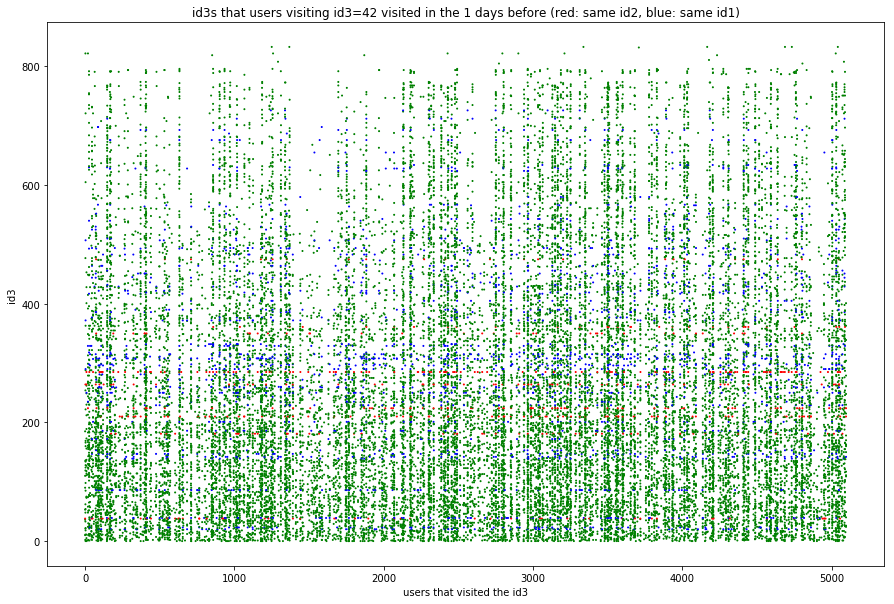

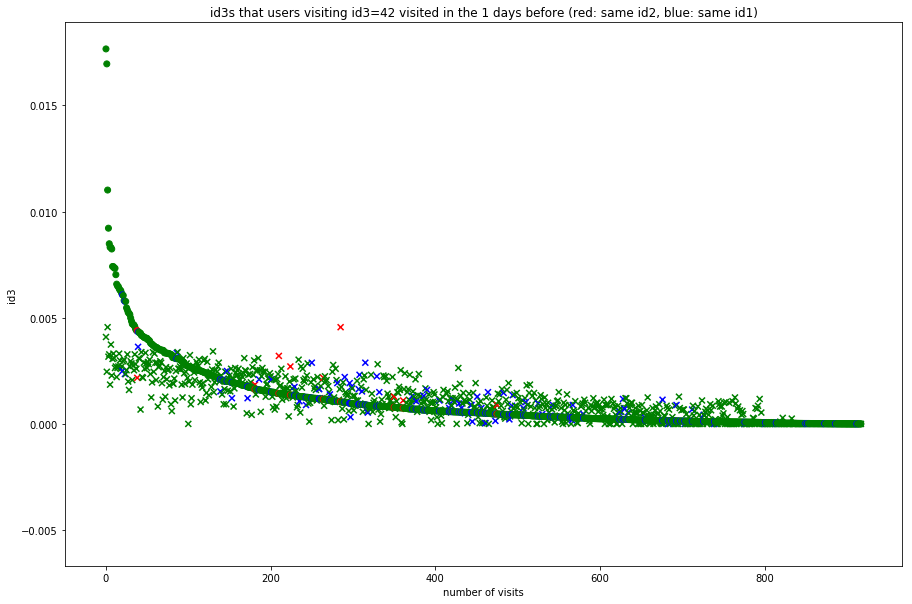

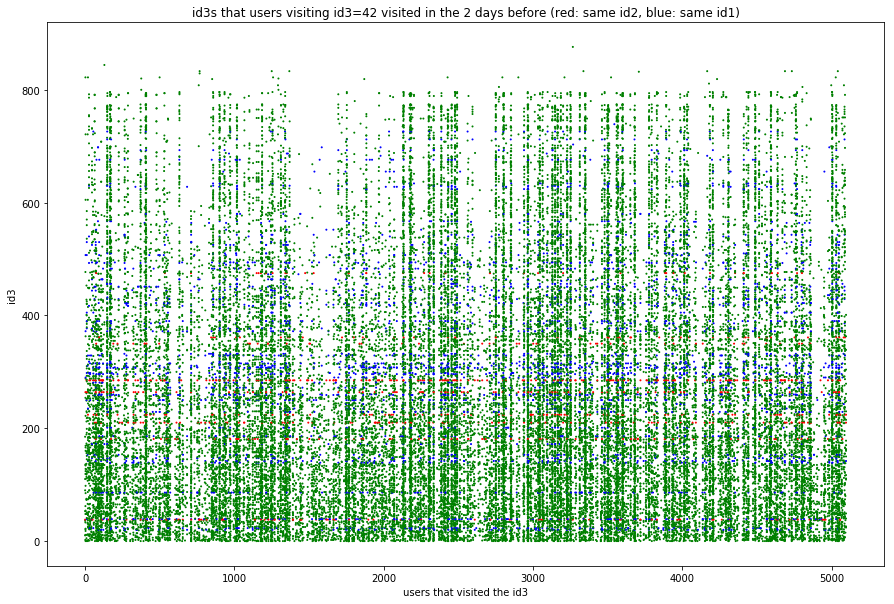

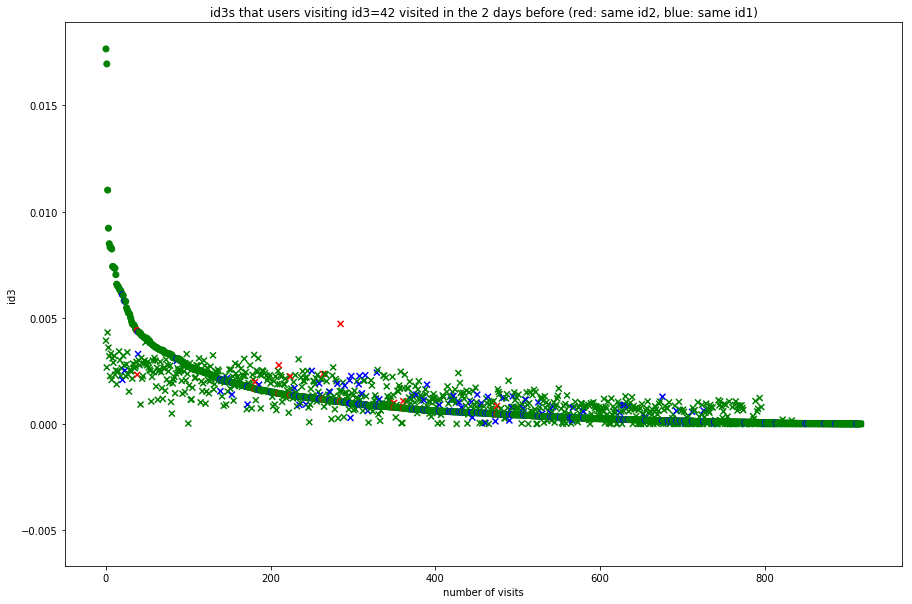

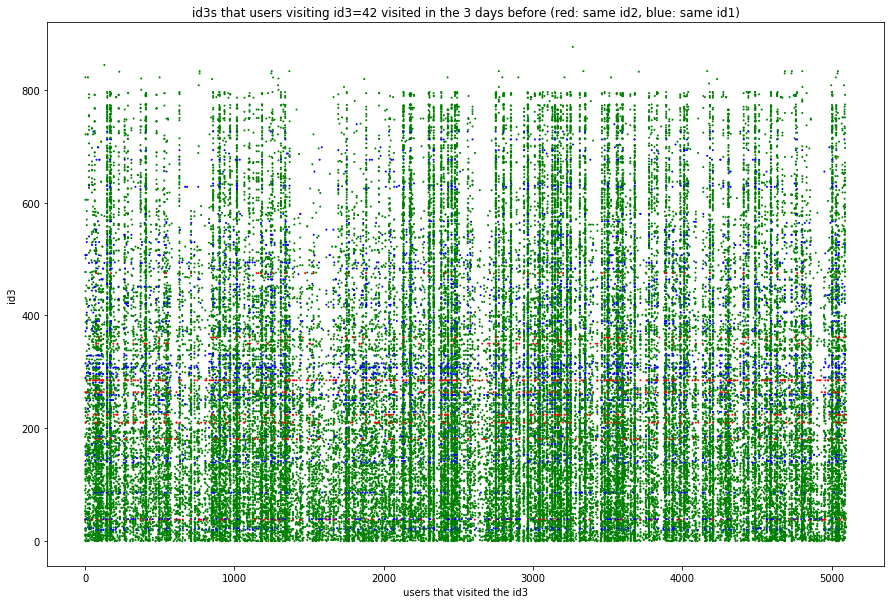

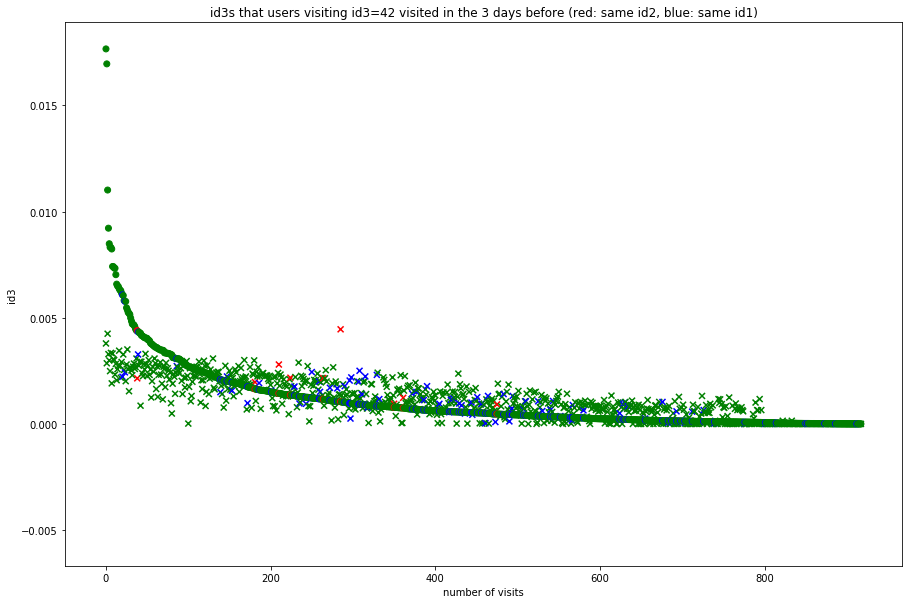

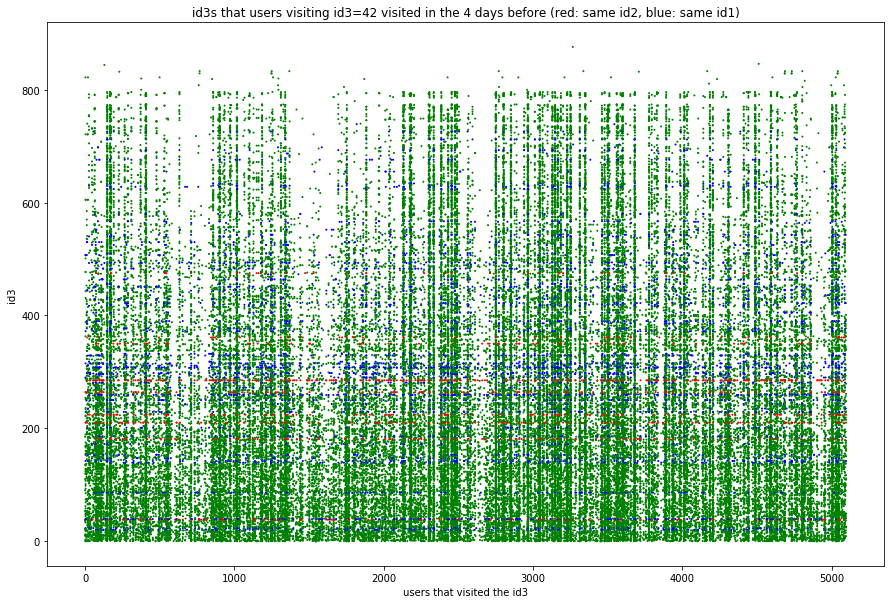

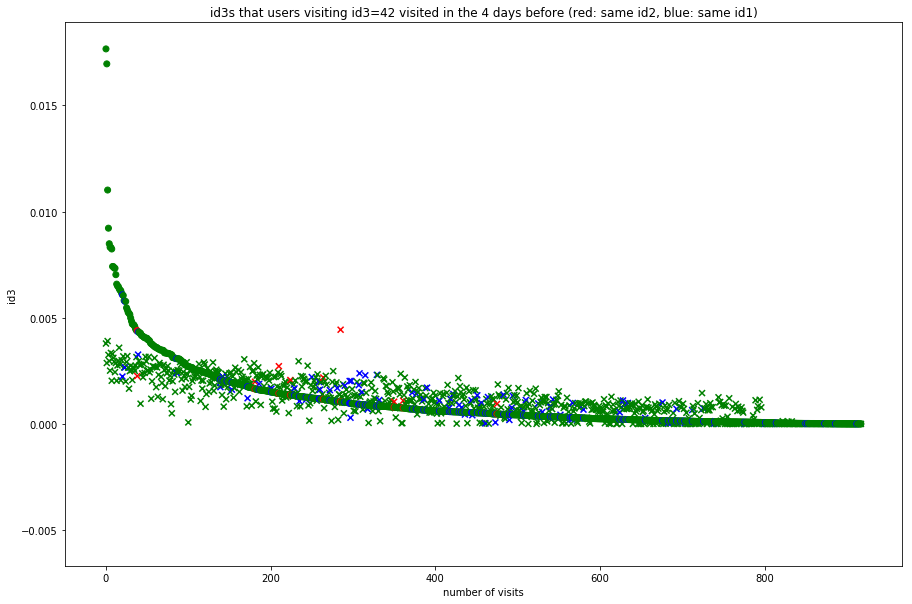

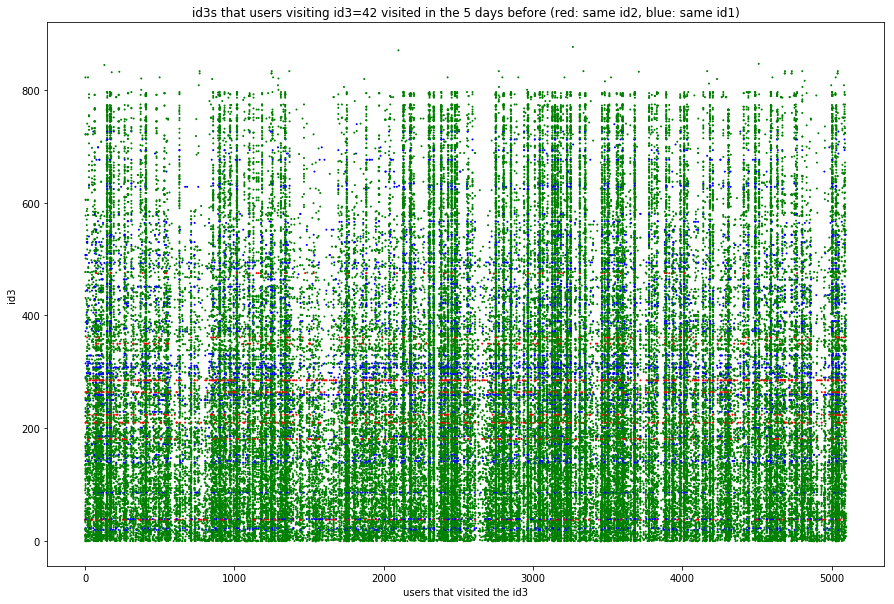

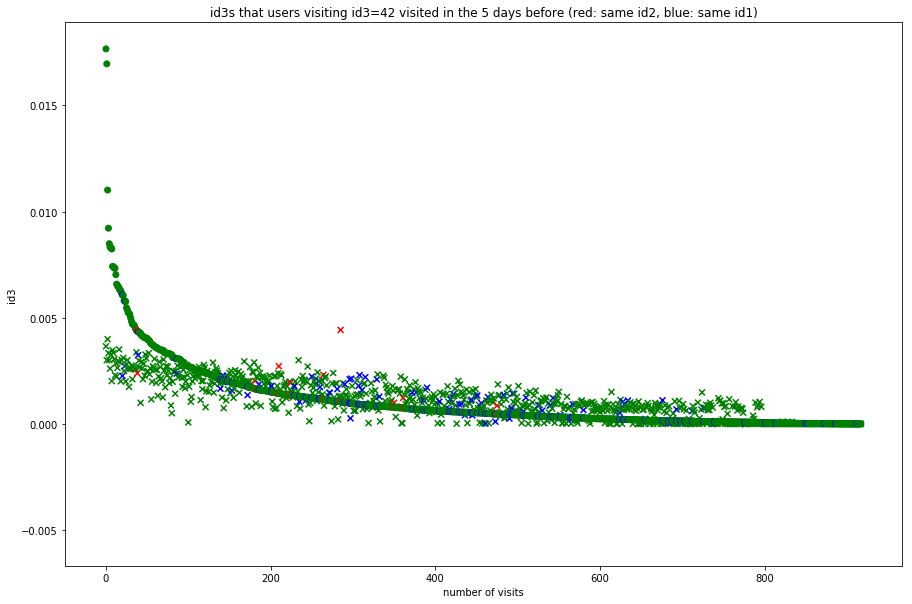

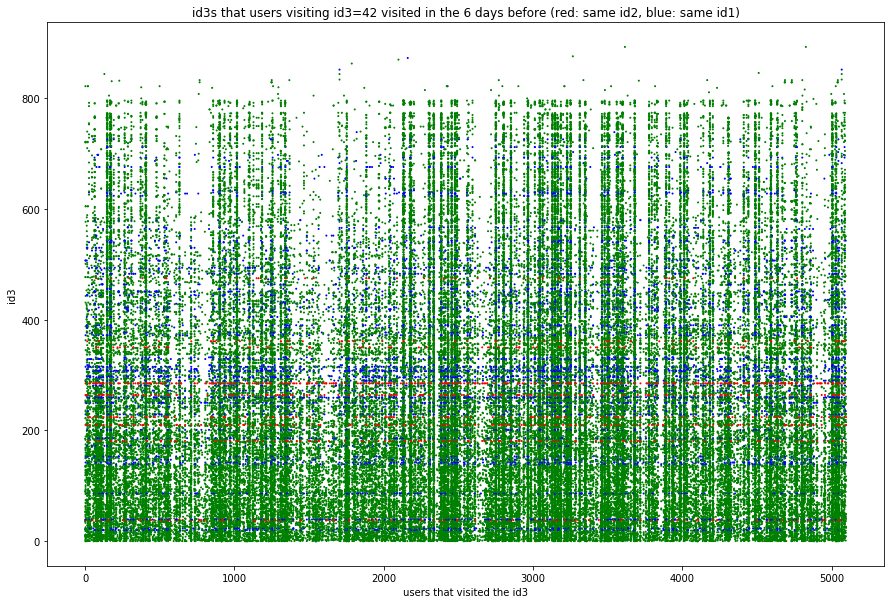

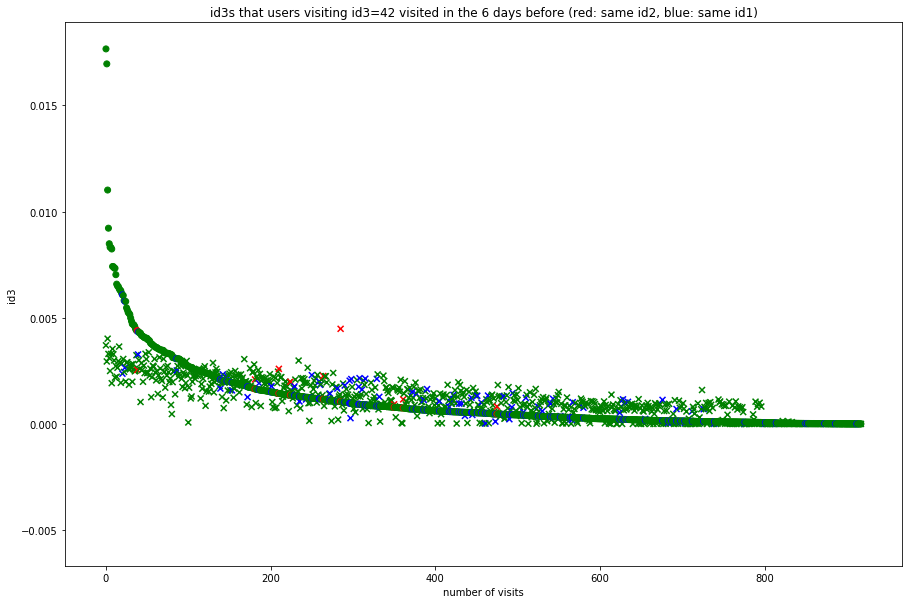

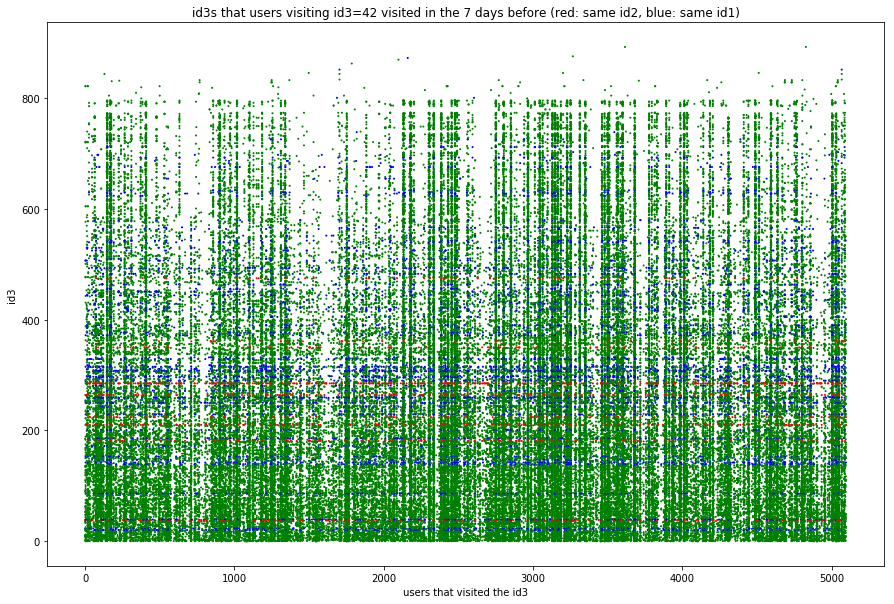

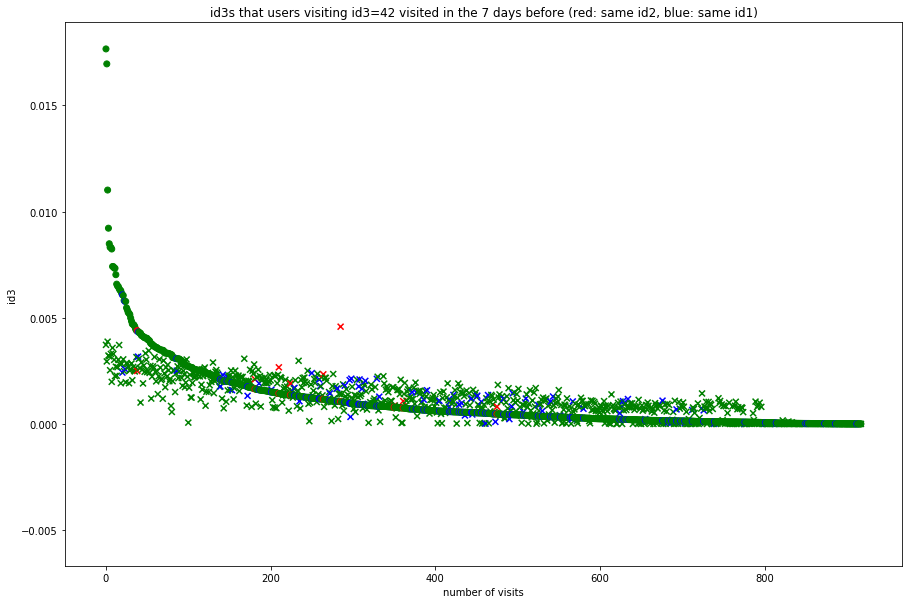

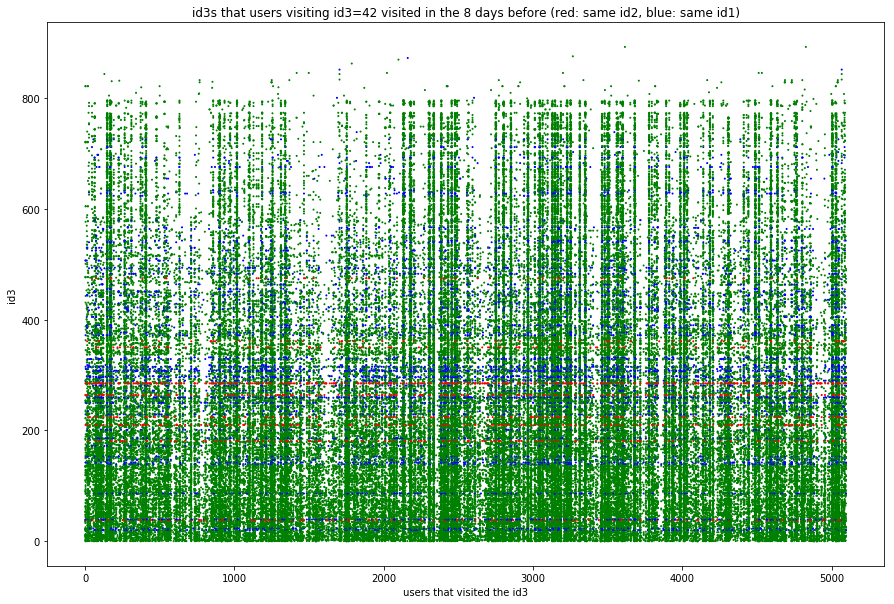

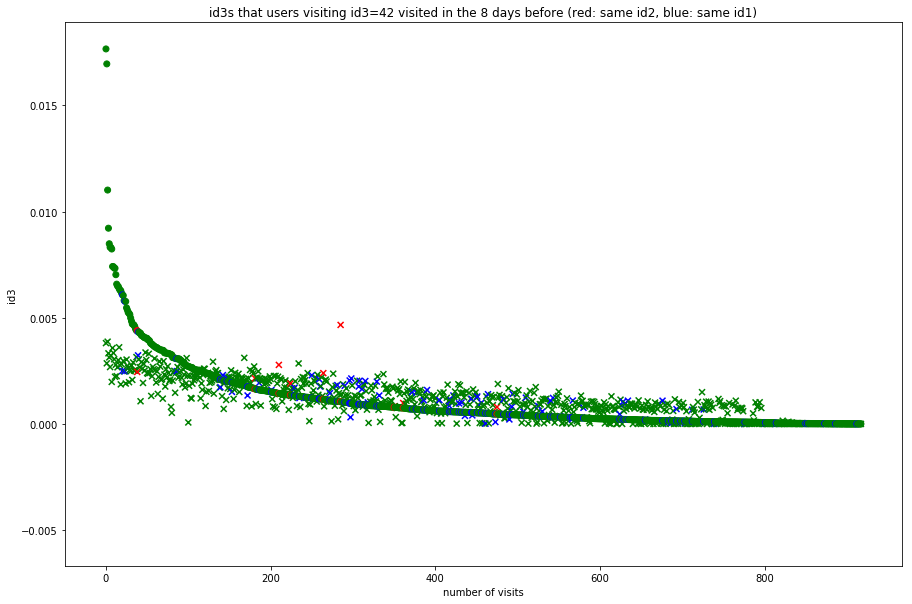

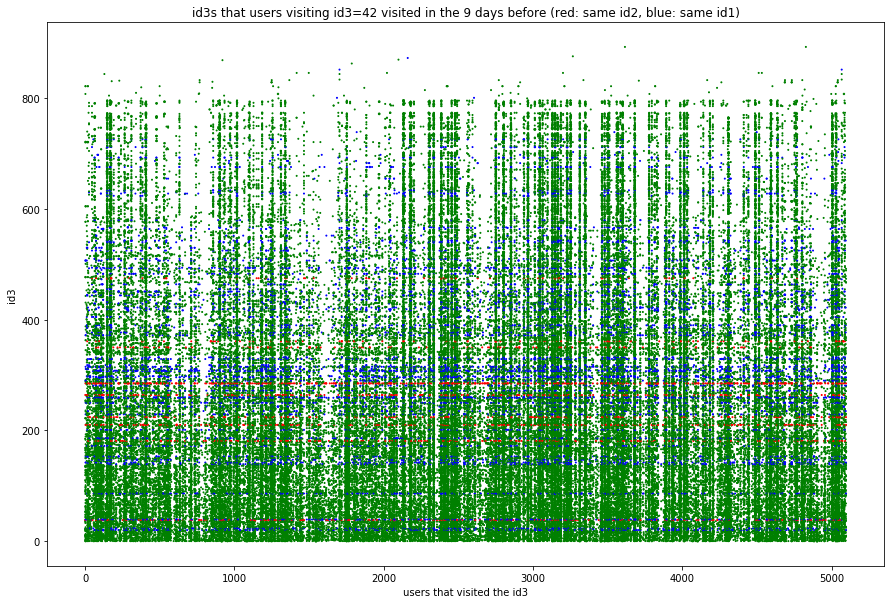

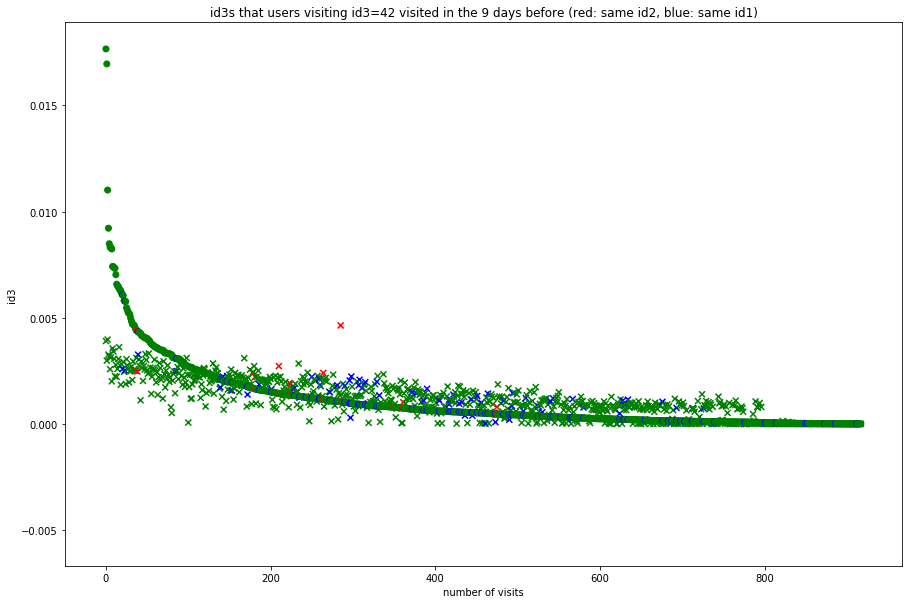

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

for duration in range(1, 10):
    X = []
    for user in id3ToUser[id3]:
        visits = userId3Visits[user]
        for day in range(minDayTrain, maxDayTrain + 1):
            if day in visits and id3 in visits[day]:
                X.append(profile(user, day, duration=duration))

    scatterx, scattery, scatters, scatterc = [], [], [], []
    for i in range(len(X)):
        for j in range(len(X[i])):
            if X[i][j]:
                scatterx.append(i)
                scattery.append(j)
                scatters.append(1 * X[i][j])
                id1Same = id21[id32[id3s[j]]] == id21[id32[id3]]
                id2Same = id32[id3s[j]] == id32[id3]
                if id2Same:
                    scatterc.append("r")
                elif id1Same:
                    scatterc.append("b")
                else:
                    scatterc.append("g")
    plt.scatter(scatterx, scattery, s=scatters, c=scatterc)
    plt.xlabel("users that visited the id3")
    plt.ylabel("id3")
    plt.title("id3s that users visiting id3={} visited in the {} days before (red: same id2, blue: same id1)".format(id3, duration))
    plt.show()
    
    totalVisits = [0 for _ in id3s]
    for i in range(len(X)):
        for j in range(len(X[i])):
            totalVisits[j] += X[i][j]
    sumTotalVisits = sum(totalVisits)
    totalVisits = [i/sumTotalVisits for i in totalVisits]
    
    sumAllVisits = sum(id3Visits.values())
    allVisits = [id3Visits[i]/sumAllVisits for i in id3s]
    
    visitsc = []
    for i in id3s:
        id1Same = id21[id32[i]] == id21[id32[id3]]
        id2Same = id32[i] == id32[id3]
        if id2Same:
            visitsc.append("r")
        elif id1Same:
            visitsc.append("b")
        else:
            visitsc.append("g")

    
    plt.scatter([i for i in range(len(id3s))], totalVisits, c=visitsc, marker="x")
    plt.scatter([i for i in range(len(id3s))], allVisits, c=visitsc)
    plt.xlabel("number of visits")
    plt.ylabel("id3")
    plt.title("id3s that users visiting id3={} visited in the {} days before (red: same id2, blue: same id1)".format(id3, duration))
    plt.show()